In [2]:
from datetime import datetime

import torch
import torchvision
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import torch.distributions as D
from torch.utils.tensorboard import SummaryWriter
import torch.utils.data as data_util
import matplotlib.pyplot as plt
from IPython import display

transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

training_data = datasets.MNIST(root="../data/MINST", download=True, train=True, transform=transform)
validation_data = datasets.MNIST(root="../data/MINST", download=True, train=False, transform=transform)

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=100, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=100, shuffle=False)

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
class Animator:
    """For plotting data in animation."""

    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(3.5, 2.5),
    ):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


In [3]:
# softmax = nn.Softmax(dim=0)
# sigmoid = nn.Sigmoid()
import torch.nn.functional as F

class MNISTModel(nn.Module):

    def __init__(self, total_class = 12, input_shape = 28*28):
        super(MNISTModel, self).__init__()
        random_uniform_val = torch.rand(total_class)
        self.mean = nn.Parameter(random_uniform_val/random_uniform_val.sum())
        self.covariance = nn.Parameter(torch.full((total_class,input_shape),1/total_class))

        
    def forward(self,data):
        # _lambda = 0.9 
        # resulting_tensor = self.covariance.clone()
        # resulting_tensor = resulting_tensor.detach()
        # print(self.covariance)
        # for i in range(12):
        #     resulting_tensor[i] = _lambda * torch.diag(torch.diag(resulting_tensor[i])) + (1 - _lambda) * resulting_tensor[i]
        # current_m = self.update(F.softmax(self.mean), F.sigmoid(self.covariance))
        current_m = self.update(self.mean, self.covariance)
        model_prob = current_m.log_prob(data)
        # print(self.mix_model.event_shape)
        # print(len(self.mix_model.event_shape))
        # expanded = torch.unsqueeze(data,len(self.mix_model.event_shape))
        # val1 = self.mix_model.component_distribution.log_prob(expanded) + self.mix_model.mixture_distribution.logits
        # covariance = D.Categorical(logits=val1).probs
        # print(model_prob.shape,covariance.shape)
        return -sum(model_prob)/data.shape[0]
    
    def update(self,mean,covariance):
        return D.MixtureSameFamily(D.Categorical(mean),D.Independent(D.Normal(covariance), reinterpreted_batch_ndims=1))

model = MNISTModel()


/var/folders/75/_0h54l8n6ys6k7klg1v8zggh0000gn/T/ipykernel_4701/4036217453.py:58: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


NameError: name 'softmax' is not defined

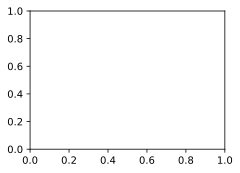

In [4]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

def train_one_epoch(animator,epoch):
    last_loss = 0.
    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        batch_size = inputs.shape[0]
        inputs = torch.reshape(inputs,(batch_size,28*28))
        inputs = torch.where(inputs > 0, 1.0, 0.0)
        optimizer.zero_grad()
        output = model(inputs)
        output.backward()
        optimizer.step()
        # print(output.item())
        animator.add(epoch + (i + 1), (output.item()/100))        

    return last_loss

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/MNIST_{}'.format(timestamp))
EPOCHS = 2
best_vloss = 1_000_000.
animator = Animator(
        xlabel="epoch", xlim=[1, EPOCHS*len(train_dataloader)], ylim=[0, 5], legend=["train loss"]
    )
for epoch in range(EPOCHS):
    model.train(True)
    avg_loss = train_one_epoch(animator,epoch*len(train_dataloader))